# AM207 Final Project

Paper: *Learned Uncertainty-Aware (LUNA) Bases for Bayesian Regression using Multi-Headed Auxiliary Networks*

207Notes:
 - (sneaky 205 q) 
    - minimum of trace in obj function
    - consider step size stability in the cosine similar FD (larger h)
    - ADAM vs SGD w/ momentum vs cyclic annealling of learning rate

 - NOTE: NLM gets comparable to LUNA if there are more features

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys

# our libraries
import utils
from nlm import NLM
from feed_forward import Feedforward
import bayes_helpers as bh

### Generate Data

In [2]:

gap = True
if gap == True:
    number_of_points = 200
    x_train, y_train, x_test = utils.generate_data(number_of_points)
else:
    df = pd.read_csv("HW8_data.csv")
    x_train = np.array(df["x"])
    y_train = np.array(df["y"])
    x_test = np.linspace(x_train.min()-1,x_train.max()+1,200)

x_train = x_train.reshape((1, -1))
y_train = y_train.reshape((1, -1))
x_test = x_test.reshape((1, -1))




#### Define NN Hyperparameters

In [12]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 7
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1,
          'optimizer':'adam'}


### Run Vanilla Nueral Network

 Iteration 14000 lower bound 46.95311148585835; gradient mag: 3.89735926292225845(200, 1)


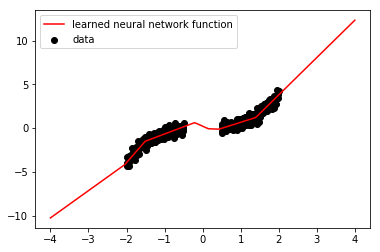

In [4]:
utils.run_toy_nn(Feedforward,architecture,params,random,x_train,y_train,x_test)

### NLM Demo

In [5]:
# test
prior_var = 1.0
y_var = 2.0
test_nlm = NLM(prior_var,y_var, architecture, random_state = np.random.RandomState(0))

In [9]:
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1,
          'optimizer':'adam'}
test_nlm.train(x_train,y_train, params)

 Iteration 4000 lower bound 46.95321380406209; gradient mag: 3.9897022489221218
Done Training


In [10]:
posterior_predictives, posterior_predictive_samples = test_nlm.predict(x_test)

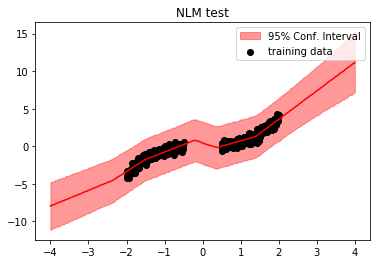

In [11]:
bh.viz_pp_samples(x_train, y_train,x_test.flatten(),posterior_predictive_samples,"NLM test")